# Clasificación de imágenes (CIFAR-10 data-set)

En este Jupyter Notebook mostraremos cómo clasificar un dat-set de 60,000 imágenes para su correcta clasificación.
Nos encontramos ante un claro ejemplo de clasificación, para lo cual haremos uso de una red profunda convolucional que terminará en una capa de salida densa fully-connected del tamaño del número de etiquetas del que consta nuestro data-set.

In [1]:
# Importamos las librerías que vamos a usar en este cuaderno.

import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.models import Sequential
from keras.utils import np_utils

# Para silenciar posibles warnings de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


Como en todos los cuadernos de esta serie, se está trabajando con una versión de Python 3.5.2 (Anaconda) y con una versión de TensorFlow:

In [2]:
tf.__version__

'1.8.0'

## Obtención de los datos

El data-set que vamos a usar ocupa aproximadamente 170 MB y se descargará automáticamente desde los tutoriales de ejemplo de Keras.

In [3]:
from keras.datasets import cifar10


Ya tenemos el CIFAR-10 data-set, que está compuesto por 50,000 imágenes de entrenamiento y 10,000 imágenes de testeo, cada una con su correspondiente etiqueta (label). Cargamos el data-set con la función load_data():

In [4]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

La dimensión de cada una de las imágenes es de `(32,32,3)`, con una altura y anchua de 32 píxeles y 3 canales RGB.

In [5]:
num_train, img_channels, img_rows, img_cols =  train_images.shape
num_train, img_channels, img_rows, img_cols


(50000, 32, 32, 3)

In [6]:
num_test, _, _, _ =  test_images.shape
num_test, img_channels, img_rows, img_cols

(10000, 32, 32, 3)

### Muestra de ejemplos del dataset. Función para representación de las imágenes del dataset

En el CIFAR-10 data-set contamos con imágenes de 10 clases distintas: aviones, coches, pájaros, perros, gatos, cérvidos, ranas, equinos, barcos y camiones:

In [7]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

Nos fabricamos una función de representación de imágenes sencilla juntos con sus etiquetas:

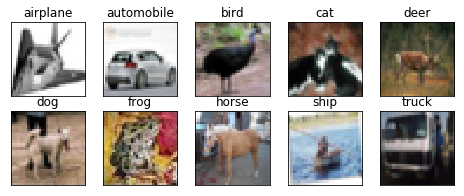

In [8]:
fig = plt.figure(figsize=(8,3))
for i in range(len(class_names)):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels == i)[0]
    features_idx = train_images[idx]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Preprocesado de los datos

#### One-Hot Encoding de las etiquetas

La etiqueta de cada imagen se ha convertido de un número a un vector cuya longitud equivale al número de clases posibles. Para una determinada etiqueta correspondiente a un número `i`, nos encontramos con que todos los elementos de ese array son `0` salvo el elemento i-ésimo, que se deja como un `1`. Por ejemplo:

In [9]:
# Normalizamos el train y el test data-set entre 0 y 1
train_features = train_images.astype('float32') / 255.
test_features = test_images.astype('float32') / 255.

# Convertimos las etiquetas a variables One-Hot Encoded

num_classes = len(np.unique(train_labels))

train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Con esto ya tendríamos preparados nuestros datos para poder hacer uso en el entrenamiento de un modelo de clasificación:

### Definición de una red convolucional haciendo uso de Keras

La estructura de datos principal en Keras es un modelo (`model`), que está pensada para facilitar la organización de capas, pues en realidad los modelos en Keras son básicamente una secuencia de capas. La clase `keras.models.Sequential` es una envoltura para el modelo de red neuronal.

Podemos indicar de manera secuencial cómo se concatenan capas convolucionales con densas, fully connected, capas de max pool, capas de activación, etc. Se puede agregar fácilmente una capa al modelo mediante su función `add()` sin preocuparnos de las dimenasionalidades de los inputs a cada capa. Por ejemplo, un modelo para el caso que nos ocupa se construiría de la siguiente manera:

In [10]:
# Definición del modelo
# Iniciamos el modelo de manera secuencial
model = Sequential()
# Continuamos añadiendo al modelo las capas sin preocuparnos de la dimensionalidad de los inputs
# salvo en la primera capa 
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',
                 input_shape=train_features.shape[1:]))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))
# Hacemos un flattening de la última capa de Pooling
model.add(Flatten())

model.add(Dense(units=512, activation = 'relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(units=num_classes, activation='softmax'))


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Keras nos permite visualizar un resumen del modelo construido, dándonos detalles de las dimensiones de los outputs de cada capa y del número de parámetros que estarán involucrados en el entrenamiento del modelo. Para acceder a ese resumen, basta con ejecutar el siguiente comando:

In [11]:
# Model summary y ploteo del grafo
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

Nuestra tarea requerirá del entrenamiento de más de 1,2 millones de parámetros en el modelo. 

Ahora el modelo debe compilarse. Para ello, haremos uso de la función `compile()` indicando el optimizador a usar, la función de pérdida a usar y la métrica a monitorizar durante el entrenamiento.

In [12]:
# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Nos cercioramos de que tenemos una carpeta creada para el almacenamiento del checkpoint nuestro modelo.

In [13]:
checkpoint_dir = os.getcwd() + '/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

## Entrenamiento del modelo

Con las siguientes líneas iniciamos el entrenamiento del modelo:

In [14]:
# Checkpoint Best Convolutional Neural Network Model Only

filepath= checkpoint_dir + "/weights.best.hdf5"

# Intentaremos guardar un checkpoint cada vez que acabe una Epoch (period=1) en base a la predicción de validación 'val_acc'.
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]

start = time.time()

# Haciendo uso de la función fit() ajustaremos nuestros modelo a los datos provistos.
model_info = model.fit(train_features, train_labels, 
                       batch_size=128, nb_epoch=10, 
                       validation_data = (test_features, test_labels),
                       callbacks=callbacks_list,
                       verbose=1)
end = time.time()

/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 470s - loss: 1.5402 - acc: 0.4405 - val_loss: 1.2137 - val_acc: 0.5652
Epoch 2/10
50000/50000 [==============================] - 405s - loss: 1.1450 - acc: 0.5921 - val_loss: 1.0194 - val_acc: 0.6394
Epoch 3/10
50000/50000 [==============================] - 426s - loss: 0.9556 - acc: 0.6631 - val_loss: 0.8427 - val_acc: 0.7068
Epoch 4/10
50000/50000 [==============================] - 402s - loss: 0.8330 - acc: 0.7081 - val_loss: 0.7622 - val_acc: 0.7331
Epoch 5/10
50000/50000 [==============================] - 404s - loss: 0.7339 - acc: 0.7425 - val_loss: 0.7279 - val_acc: 0.7479
Epoch 6/10
50000/50000 [==============================] - 404s - loss: 0.6673 - acc: 0.7644 - val_loss: 0.6940 - val_acc: 0.7603
Epoch 7/10
50000/50000 [==============================] - 405s - loss: 0.6066 - acc: 0.7857 - val_loss: 0.6583 - val_acc: 0.7716
Epoch 8/10
50000/50000 [=======================

### Función que nos permitirá monitorizar la evolución de la precisión y la función de pérdida

In [15]:
def plot_model_history(history):
    fig, ax = plt.subplots(1, 2,figsize=(20,7))
    
    # Resumen de la evolución de la precisión
    ax[0].plot(range(1, len(history.history['acc']) + 1), history.history['acc'])
    ax[0].plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'])
    ax[0].set_ylabel('Precision')
    ax[0].set_xlabel('Epoch')
    ax[0].set_xticks(np.arange(1, len(history.history['acc']) + 1), len(history.history['acc']) / 10)
    ax[0].legend(['train', 'validation'], loc='best')
    
    # Resumen de la evolución de la función de pérdida
    ax[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    ax[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xticks(np.arange(1, len(history.history['loss']) + 1), len(history.history['loss']) / 10)
    ax[1].legend(['train', 'validation'], loc='best')
    
    plt.show()

### Definición de una función para calcular la precisión de testeo

In [16]:
def accuracy(test_image, test_label, model):
    
    # Haciendo uso de model.predict
    result = model.predict(test_image)
    
    # La predicción de la clase se obtiene haciendo uso de np.argmax()
    predicted_class = np.argmax(result, axis=1)
    
    # Contamos con la clase verdadera del test dataset,
    # para compararla con la clase predicha
    true_class = np.argmax(test_label, axis=1)
    
    # Calculamos la precisión sobre el test dataset de nuestro clasificador
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Keras nos facilita una manera muy rápida de evaluar la bondad de nuestro modelo con la función `evaluate()`.
No sería necesario hacernos una función como la anterior para calcular la accuracy.

In [17]:
# Bondad del modelo entrenado teniendo en cuenta el test data-set.
scores = model.evaluate(test_features, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 30s    
Test loss: 0.630323764849
Test accuracy: 0.7905


Como resumen del entrenamiento y del testeo, a continuación se ofrece:

1. Evolución de la precisión y de la función de pérdida.
2. Precisión sobre el test data-set.

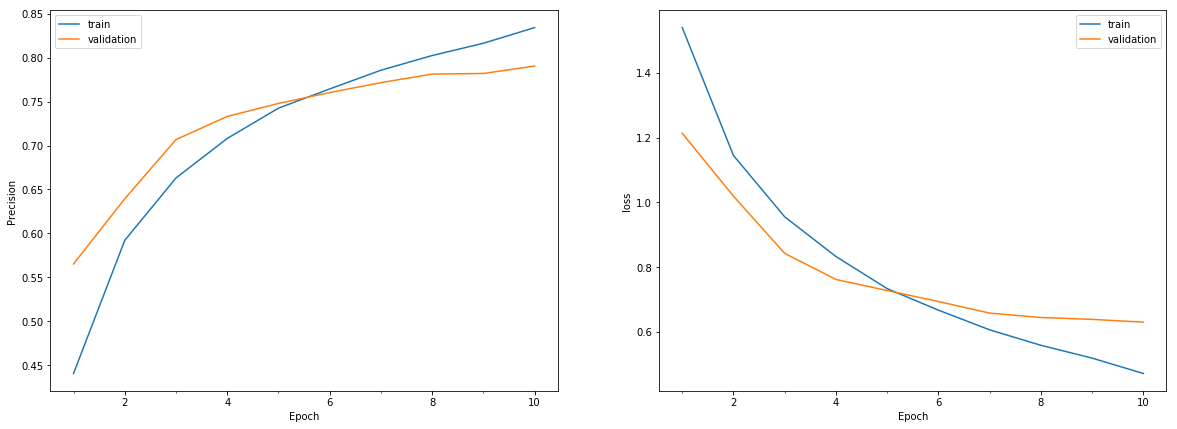

El entrenamiento del modelo duró 4127.29 segundos
La Accuracy sobre el test data-set es de: 79.05 %


In [18]:
plot_model_history(model_info)
print("El entrenamiento del modelo duró %0.2f segundos"%(end - start))

# compute test accuracy
print("La Accuracy sobre el test data-set es de: %0.2f %%" %accuracy(test_features, test_labels, model))